In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
[WinError 2] The system cannot find the file specified: '/content'


fatal: destination path 'medical-ai' already exists and is not an empty directory.


Great! You clicked on it correctly. Now let's get started.


In [2]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [3]:
df = pd.read_csv("C:/Users/trive/OneDrive/Desktop/Lungs Disease/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [5]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [6]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [7]:
rootdir = "C:/Users/trive/OneDrive/Desktop/Lungs Disease/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [8]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [9]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

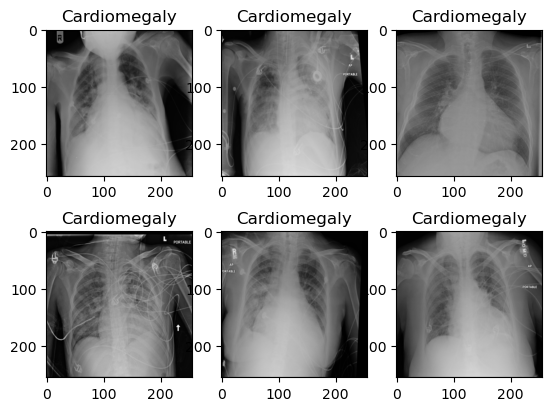

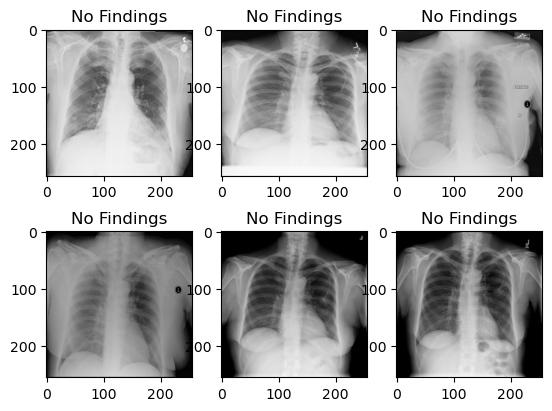

In [10]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [11]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

Done compiling the model!


In [12]:
# Define our example directories and files
base_dir = rootdir = "D:/Mini project/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Done funneling data!


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

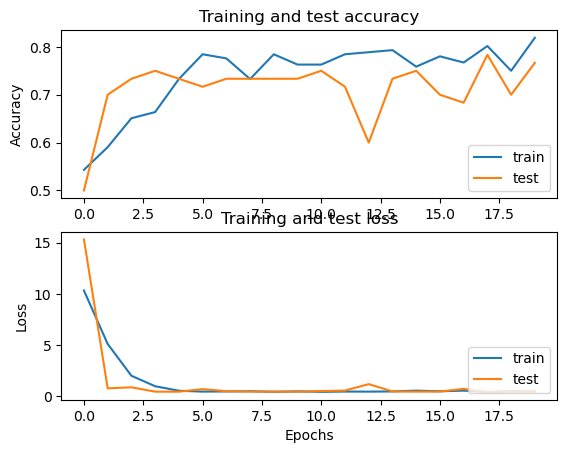

In [59]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


In [66]:
 def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [55]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 164ms/step
Done inference!


In [56]:
df.head()

,filepath,filename,label,guess,confidence
0,C:/Users/trive/OneDrive/Desktop/Lungs Disease/...,00013615_052.jpg,pos,pos,0.998986
1,C:/Users/trive/OneDrive/Desktop/Lungs Disease/...,00025969_000.jpg,pos,pos,0.995741
2,C:/Users/trive/OneDrive/Desktop/Lungs Disease/...,00005532_000.jpg,pos,pos,0.990169
3,C:/Users/trive/OneDrive/Desktop/Lungs Disease/...,00004344_013.jpg,pos,pos,0.988239
4,C:/Users/trive/OneDrive/Desktop/Lungs Disease/...,00010381_000.jpg,pos,pos,0.969333


1/1 [==============================] - 0s 179ms/step


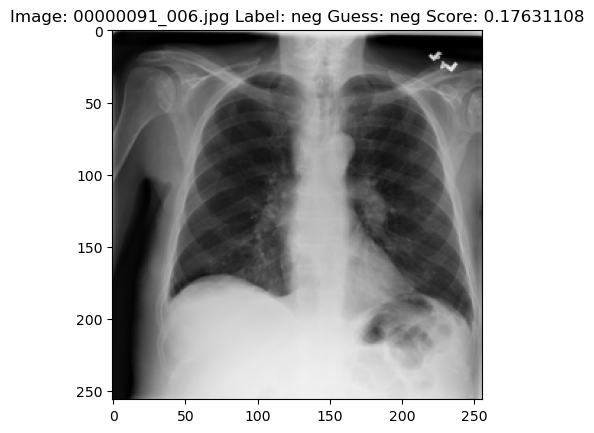

In [62]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [63]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.998986
5,00004893_085.jpg,pos,pos,0.961998
10,00011557_003.jpg,pos,pos,0.930916
15,00000092_000.jpg,neg,pos,0.844775
20,00004342_002.jpg,pos,pos,0.720264
25,00000090_006.jpg,neg,pos,0.687833
30,00001373_039.jpg,pos,pos,0.629214
35,00000087_000.jpg,neg,pos,0.574894
40,00015064_001.jpg,pos,neg,0.375288
45,00000090_010.jpg,neg,neg,0.260861
